# Service rates analysis

The service rates of support engineers working each type of queue can be approximated by taking the time between each response that completes an SLA event.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')

## Source data

The source data for arrival rates are derived from these Zendesk Explore queries:

* [L&R](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/58143932)
* [SaaS](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/58143382)
* [SaaS Account](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/58143412)
* [Self-Managed](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/57679032)

These queries get a list of all updates which resulted in a support engineer completing an SLA event.

Metrics:

1. D_COUNT(Updates)

Rows:

1. Updater ID
1. Ticket form (includes `L&R`, `SaaS`, `SaaS Account`, `Self-Managed` depending on query)
1. Update - Timestamp

Filters:

1. Updater role (includes `Admin`, `Agent`)
1. Comment type (includes only `Public`)
1. Changes - Previous value (includes only `new`, `open`, `hold`)
1. Update ticket status (includes only `closed`, `deleted`, `pending`, `solved`)

Note: 

* Dates are filtered under "Advanced" to "From of beginning of `2020-01-01`" to "To the end of `1 month in the past`".
* **IMPORTANT** Your Zendesk profile timezone must be set to UTC.


## Importing data

As the dataset is too large for Zendesk Explore to generate without timing out, we split it into four separate queries. We'll need to join them back up into a single dataset.

In [2]:
service_data_files = {
    'L&R': '../_inputs/service_data_lr_-_up_to_2021-02-28.csv',
    'SaaS': '../_inputs/service_data_saas_-_up_to_2021-02-28.csv',
    'SaaS Account': '../_inputs/service_data_saas_account_-_up_to_2021-02-28.csv',
    'Self-Managed': '../_inputs/service_data_sm_-_up_to_2021-02-28.csv'
}

service_dfs = []
for filename in service_data_files.values():
    service_dfs.append(pd.read_csv(filename))

service_df = pd.concat(service_dfs, ignore_index=True)
service_df['Update - Timestamp'] = pd.to_datetime(service_df['Update - Timestamp'])
service_df.sort_values(['Updater ID', 'Update - Timestamp'], inplace=True)

print(service_df.shape)

(84904, 4)


## Data processing

For some reason, there are timestamps with more than one update associated with them. We'll discard them.

In [3]:
# Discard timestamps with more than 1 updates
single_update_mask = service_df['Updates'] == 1
service_df = service_df[single_update_mask]

print(service_df.shape)

(84899, 4)


We now calculate the time between responses for each support engineer to approximate the amount of time taken to service each customer message.

_Note: We cannot skip entries when the date changes, as GitLab Support runs on a 24/5 basis globally. We'll instead handle breaks between work days later._

In [4]:
# Calculate time between agent responses
prev_row = pd.Series([], dtype=object)
for i, row in service_df.iterrows():
    # Skip row if first row or Updater ID changes
    if not (prev_row.empty or (row['Updater ID'] != prev_row['Updater ID'])):
        service_time = row['Update - Timestamp'] - prev_row['Update - Timestamp']
        service_df.at[i, 'Service Time (mins)'] = service_time.total_seconds() / 60
        service_df.at[i, 'Service Time (hrs)'] = service_time.total_seconds() / 60 / 60

    prev_row = row


We'll get rid of null data, as well as any rows which have a service time of 0 minutes.

In [5]:
# Get rid of null data
service_df = service_df[service_df['Service Time (mins)'].notna()]
print(service_df.shape)

(84765, 6)


In [6]:
# Get rid of zero minute service times 
service_df = service_df[service_df['Service Time (mins)'] > 0]
print(service_df.shape)

(84765, 6)


We'll now get rid of the time intervals between work days. First, let's visualise the distribution of service times between 4 hours and 36 hours.

<AxesSubplot:xlabel='Service Time (hrs)', ylabel='Count'>

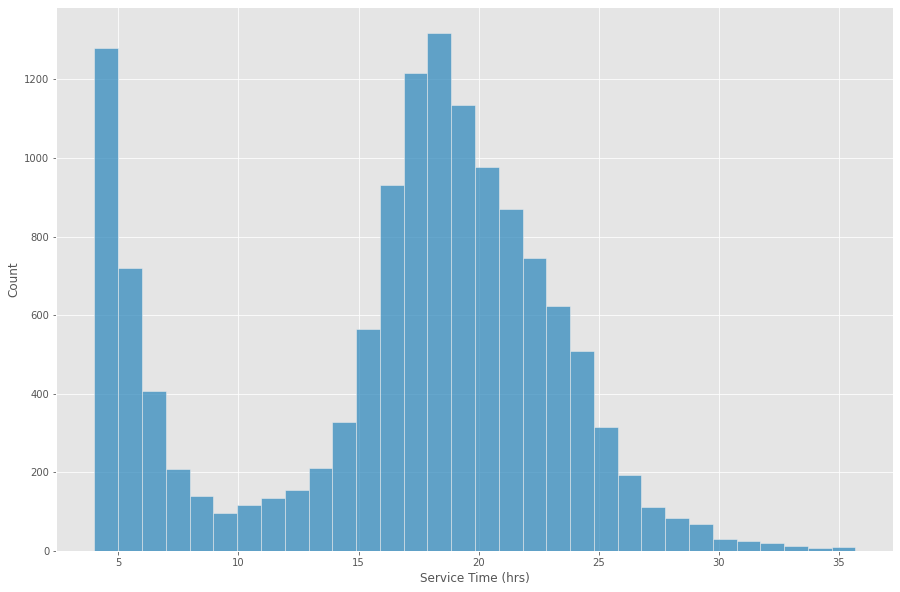

In [7]:
break_viz_mask = (service_df['Service Time (mins)'] >= 4 * 60) & (service_df['Service Time (mins)'] <= 36 * 60)
break_viz_df = service_df[break_viz_mask]

fig, ax = plt.subplots(figsize=[15, 10])
sns.histplot(data=break_viz_df, x='Service Time (hrs)', bins=32, ax=ax)

Visually, it looks like 9 hours is the minimum point between the workday and intra-workday time intervals. We'll use that as the cut off point.

In [8]:
workday_service_mask = service_df['Service Time (mins)'] < 10 * 60
workday_service_df = service_df[workday_service_mask]
print(workday_service_df.shape)

(68891, 6)


## Data exploration

In [9]:
print(workday_service_df.groupby('Ticket form').mean())

              Updates  Service Time (mins)  Service Time (hrs)
Ticket form                                                   
L&R               1.0            36.636018            0.610600
SaaS              1.0            46.826531            0.780442
SaaS Account      1.0            36.992741            0.616546
Self-Managed      1.0            71.220534            1.187009


<AxesSubplot:xlabel='Update - Timestamp', ylabel='Service Time (mins)'>

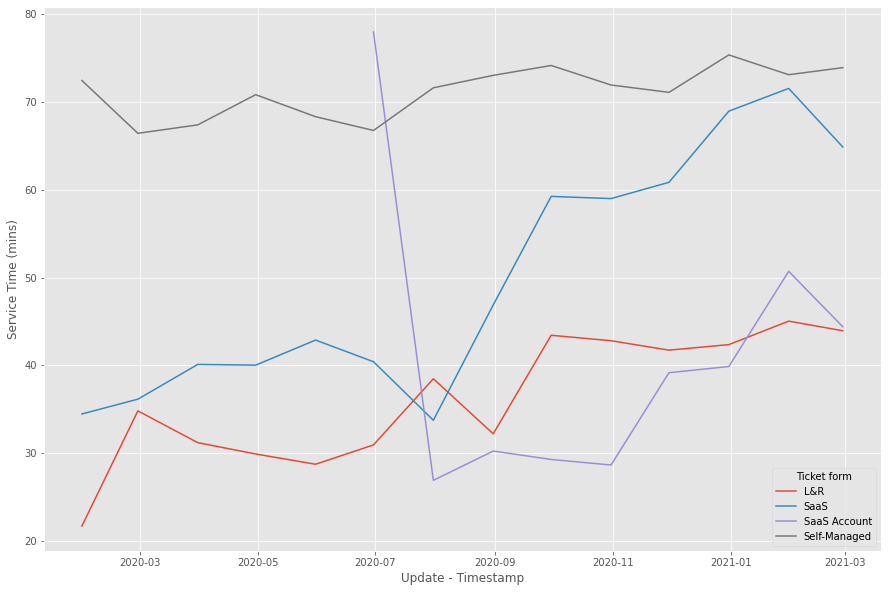

In [10]:
workday_time_series_df = workday_service_df.groupby([
    pd.Grouper('Ticket form'),
    pd.Grouper(key='Update - Timestamp', freq='M')
]).mean().reset_index().drop(columns=['Updates'])

fig, ax = plt.subplots(figsize=[15, 10])
sns.lineplot(data=workday_time_series_df, x='Update - Timestamp', y='Service Time (mins)', hue='Ticket form', ax=ax)